Here, we will explore a series of different ordination methods applied to both the prevention and reversal datasets.

Namely, we will explore the following distances

- Weighted Unifrac
- Aitchison

This will applied for both the time series and by gut location.  We will show that there is no visible signal in the fecal samples or the colon samples with respect to the treatments.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skbio.stats.composition import clr, centralize, closure
from skbio.stats.distance import DistanceMatrix, permanova, anosim
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa
from skbio import TreeNode, OrdinationResults
from gneiss.util import match
from biom import load_table
from scipy.spatial.distance import euclidean, braycurtis
from emperor import Emperor, nbinstall
import seaborn as sns
nbinstall()
%matplotlib inline

/Users/mortonjt/miniconda3/envs/bio/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
def convert_biom_to_pandas(table):
    """ Unpacks biom table into two pandas dataframes.
    
    The first dataframe will contain the count information for 
    features and samples. The second datafram will contain taxonomy 
    information for all of the OTUs.
    
    Parameters
    ----------
    table : biom.Table
    
    Returns
    -------
    pd.DataFrame
        Contingency table of counts where samples correspond 
        to rows and columns correspond to features (i.e. OTUs)
    pd.DataFrame
        A mapping of OTU names to taxonomic ids
    """

    feature_table = pd.DataFrame(np.array(table.matrix_data.todense()).T,
                             index=table.ids(axis='sample'),
                             columns=table.ids(axis='observation'))
    feature_ids = table.ids(axis='observation')
    mapping = {i: table.metadata(id=i, axis='observation')['taxonomy'] for i in feature_ids}
    # modify below as necessary.  
    # There are typically 7 levels of taxonomy.
    taxonomy = pd.DataFrame(mapping, 
                            index=['kingdom', 'phylum', 'class', 'order', 
                                   'family', 'genus', 'species']).T
    return feature_table, taxonomy

def clr_ordination(table):
    """
    Performs SVD on clr transformed data.
    
    Parameters
    ----------
    table : pd.DataFrame
        Contingency table of counts where samples correspond 
        to rows and columns correspond to features (i.e. OTUs)

    Returns
    -------
    OrdinationResults
    """
    mat = clr(centralize(closure(table+1)))
    u, s, v = np.linalg.svd(mat)
    samples = pd.DataFrame(u, index=table.index)
    features = pd.DataFrame(v, index=table.columns)
    eigvals = pd.Series(s)
    proportion_explained = (eigvals**2) / (eigvals**2).sum()
    res = OrdinationResults("clr", "clr", samples=samples, 
                            features=features, eigvals=eigvals, 
                            proportion_explained=proportion_explained)
    return res

# Metabolomics

In [3]:
ms_table = load_table('../original_data/ft-w-gnpsid-norm.biom')
metadata = pd.read_table('../original_data/potato_metadata.txt', index_col=0)

In [4]:
metadata.processing_type.value_counts()

Steamed         18
Raw             18
French Fries    18
Microwaved      18
Chips           18
Baked           18
Name: processing_type, dtype: int64

In [5]:
ms_table = pd.DataFrame(np.array(ms_table.matrix_data.todense()).T,
                        index=ms_table.ids(axis='sample'),
                        columns=ms_table.ids(axis='observation'))

Now we will generate a PCoA using Bray Curtis

In [6]:
dm = DistanceMatrix.from_iterable(ms_table.values, braycurtis)
dm.ids = ms_table.index

In [7]:
pc = pcoa(dm)

/Users/mortonjt/miniconda3/envs/bio/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:111: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.05412893007466299 and the largest is 5.7298949608902765.
  RuntimeWarning


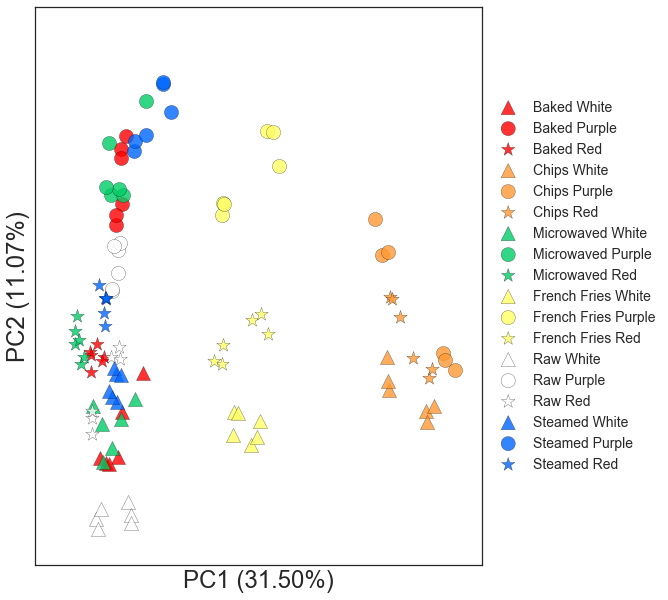

In [8]:
sns.set_style('white')
samples = pc.samples.sort_index()
metadata = metadata.sort_index()
potato_color_marker = {'White': "^", "Purple": "o", "Red": "*"}
potato_processing_color = {'French Fries' : "#ffff66",
                           'Chips': "#ff9933",
                           'Baked': '#ff0000',
                           'Steamed' : '#0066ff',
                           'Microwaved' : '#00cc66',
                           'Raw' : 'w'}
l1 = []
l2 = []
fig, ax = plt.subplots(figsize=(10, 10))
for processing_type, c in potato_processing_color.items():
    for potato_color, m in potato_color_marker.items():  
        idx = np.logical_and(metadata.cultivar_color==potato_color,
                             metadata.processing_type==processing_type)                             
        x = ax.scatter(samples.PC1.loc[idx], samples.PC2.loc[idx], 
                       s=200, c=c, marker=m, label= "%s %s" % (processing_type, potato_color),
                       alpha=0.8)
        l1.append(x)
ax.set_xlabel("PC1 ({percent:.2%})".format(percent=pc.proportion_explained.PC1), fontsize=24)
ax.set_ylabel("PC2 ({percent:.2%})".format(percent=pc.proportion_explained.PC2), fontsize=24)
ax.set_xticks([])
ax.set_yticks([])

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
fig.savefig('../results/metabolomics_heatmap.pdf')

# Prevention study

In [9]:
table = load_table('../processed_data/1706_1145_otu_table.biom')
mapping = pd.read_table('../processed_data/1706_1145_mapping.txt', index_col=0)
tree = TreeNode.read('../processed_data/97_otus.tree')
otu_table, taxonomy = convert_biom_to_pandas(table)
mapping.index = mapping['#SampleID']

In [10]:
res = clr_ordination(otu_table)

In [11]:
x = Emperor(res, mapping, remote=True)

In [12]:
x

In [13]:
tree = tree.shear(otu_table.columns)
tree.bifurcate()
for n in tree.postorder():
    if n.length is None:
        n.length = 0

In [14]:
otu_table = otu_table.astype(np.int)
unifrac_dm = beta_diversity('weighted_unifrac', otu_table.values, 
                            ids=otu_table.index, otu_ids = otu_table.columns, tree=tree)
res = pcoa(unifrac_dm)
y = Emperor(res, mapping, remote=True)

/Users/mortonjt/miniconda3/envs/bio/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:111: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -1.391643101105817 and the largest is 30.33028627840097.
  RuntimeWarning


In [15]:
y

Ok, looks like we have an age/time confounder.  What happens if we look at only the distal colon?

In [16]:
otu_table, mapping = match(otu_table, mapping)

In [17]:
distal_mapping = mapping.loc[mapping.body_site=='UBERON:distal colon'] 
proximal_mapping = mapping.loc[mapping.body_site=='UBERON:proximal colon'] 

distal_table, distal_mapping = match(otu_table, distal_mapping)
proximal_table, proximal_mapping = match(otu_table, proximal_mapping)

In [18]:
res = clr_ordination(distal_table) 
x = Emperor(res, mapping, remote=True)

In [19]:
x

# Permanova on processing type on distal last timepoint

In [20]:
clrdm = DistanceMatrix.from_iterable(clr(distal_table+1), euclidean)
clrdm.ids = distal_table.index

Take away
- There is a clear confound with respect to age and time
- There is something weird going on with age and time - they disagree in the mapping file.
- There may be a difference with respect to the distal colon

In [21]:
permanova(clrdm, distal_mapping.processing, permutations=999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      62
number of groups                  5
test statistic               1.8259
p-value                       0.002
number of permutations          999
Name: PERMANOVA results, dtype: object

In [22]:
distal_mapping = mapping.loc[mapping.body_site=='UBERON:distal colon'] 
distal_table, distal_mapping = match(otu_table, distal_mapping)

distal_mapping = distal_mapping.loc[distal_mapping.processing!='HCD'] 
distal_mapping = distal_mapping.loc[distal_mapping.processing!='Control'] 
distal_table, distal_mapping = match(distal_table, distal_mapping)

In [23]:
unifrac_dm = beta_diversity('weighted_unifrac', distal_table.values, 
                            ids=distal_table.index, otu_ids = distal_table.columns, tree=tree)
res = pcoa(unifrac_dm)
permanova(unifrac_dm, distal_mapping.processing, permutations=999)

/Users/mortonjt/miniconda3/envs/bio/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:111: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.045662102997963264 and the largest is 1.1652528241531748.
  RuntimeWarning


method name               PERMANOVA
test statistic name        pseudo-F
sample size                      46
number of groups                  3
test statistic              1.59876
p-value                       0.074
number of permutations          999
Name: PERMANOVA results, dtype: object

In [24]:
unifrac_dm = beta_diversity('weighted_unifrac', proximal_table.values, 
                            ids=proximal_table.index, otu_ids = proximal_table.columns, tree=tree)
res = pcoa(unifrac_dm)
permanova(unifrac_dm, proximal_mapping.processing, permutations=999)

/Users/mortonjt/miniconda3/envs/bio/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:111: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.0997992837051767 and the largest is 1.6405594463860067.
  RuntimeWarning


method name               PERMANOVA
test statistic name        pseudo-F
sample size                      62
number of groups                  5
test statistic              2.12169
p-value                       0.005
number of permutations          999
Name: PERMANOVA results, dtype: object

In [25]:
Emperor(res, proximal_mapping, remote=True)

In [26]:
proximal_mapping = mapping.loc[mapping.body_site=='UBERON:proximal colon'] 
proximal_table, proximal_mapping = match(otu_table, proximal_mapping)

proximal_mapping = proximal_mapping.loc[proximal_mapping.processing!='HCD'] 
proximal_mapping = proximal_mapping.loc[proximal_mapping.processing!='Control'] 
proximal_table, proximal_mapping = match(proximal_table, proximal_mapping)

In [27]:
unifrac_dm = beta_diversity('weighted_unifrac', proximal_table.values, 
                            ids=proximal_table.index, otu_ids = proximal_table.columns, tree=tree)
res = pcoa(unifrac_dm)

/Users/mortonjt/miniconda3/envs/bio/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:111: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.08173095928080709 and the largest is 1.277343449623838.
  RuntimeWarning


In [28]:
Emperor(res, proximal_mapping, remote=True)

In [29]:
permanova(unifrac_dm, proximal_mapping.processing, permutations=999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      47
number of groups                  3
test statistic              1.07572
p-value                       0.354
number of permutations          999
Name: PERMANOVA results, dtype: object